In [9]:
import pandas as pd
import numpy as np
import yfinance as yf
import time
from sklearn.preprocessing import StandardScaler
import warnings
import matplotlib.pyplot as plt
import torch

warnings.filterwarnings("ignore")

In [ ]:
# uncomment following line to download Chronos
# ! pip install chronos-forecasting

In [10]:
stock_symbols = [
    "RIVN",  # Rivian Automotive
    "TSLA",  # Tesla
    "NIO",   # Nio Inc ADR
    "XPEV",  # Xpeng Inc ADR
    "EVGO",  # Evgo Inc
    "LI",    # Li Auto Inc ADR
    "INDI",  # Indie Semiconductor Inc Class A
    "CHPT",  # Chargepoint Holdings Inc Class A
    "LCID",  # Lucid Group Inc
    "LAZR"   # Luminar Technologies Inc Class A
]
train_raw = yf.download(stock_symbols, start='2024-01-01', end='2024-08-31')['Close']
train_length = len(train_raw)
test = yf.download(stock_symbols, start='2024-09-01', end='2024-09-30')['Close']
test_length = len(test)
train_test_raw = pd.concat([train_raw, test])
train_raw

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed


Ticker,CHPT,EVGO,INDI,LAZR,LCID,LI,NIO,RIVN,TSLA,XPEV
Date,,,,,,,,,,
2024-01-02,2.17,3.30,7.58,46.799999,4.15,34.590000,8.42,21.10,248.419998,14.04
2024-01-03,2.06,3.14,7.35,44.700001,3.96,35.740002,8.50,20.32,238.449997,14.23
2024-01-04,2.11,3.13,7.07,45.450001,3.89,35.110001,8.27,19.50,237.929993,13.79
2024-01-05,2.23,3.09,7.08,49.049999,3.78,34.160000,8.06,19.08,237.490005,13.09
2024-01-08,2.23,3.19,7.51,49.650002,3.80,34.000000,7.93,19.58,240.449997,12.70
...,...,...,...,...,...,...,...,...,...,...
2024-08-26,1.84,4.36,4.22,15.600000,4.26,20.730000,4.03,14.36,213.210007,7.51
2024-08-27,1.83,4.34,4.12,15.600000,4.11,21.219999,4.00,14.48,209.210007,8.00
2024-08-28,1.77,4.14,3.89,15.000000,3.94,17.799999,3.70,13.83,205.750000,7.28


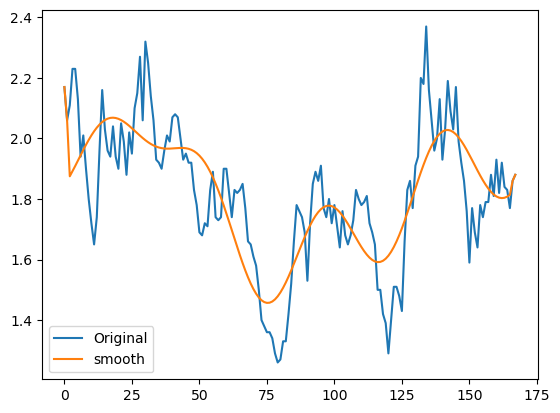

In [11]:
stock = 'CHPT'
offset = 2
rft = np.fft.rfft(train_raw[stock])
rft[5:] = 0
smooth = np.fft.irfft(rft)
smooth[:offset],smooth[-offset:] = train_raw[stock][:offset].to_numpy(), train_raw[stock][-offset:].to_numpy()
plt.plot(np.arange(len(train_raw)), train_raw[stock], label = 'Original')
plt.plot(np.arange(len(train_raw)), smooth, label = 'smooth')
plt.legend()
plt.show()

In [12]:
def preprocess(data, freq):
    scaler = StandardScaler()
    rft = np.fft.rfft(data)
    rft[freq:] = 0
    smooth = np.fft.irfft(rft)
    smooth[:2], smooth[-2:] = data.iloc[:2], data.iloc[-2:]
    #smooth = scaler.fit_transform(smooth.reshape(-1,1))
    return smooth, lambda x: x

In [13]:
from chronos import ChronosPipeline
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    device_map="cpu",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)
pred_chronos_day = {}
pred_chronos_week = {}
pred_chronos_month = {}
for x in stock_symbols:
    pred_day = []
    pred_week = []
    for y in range(test_length):
        #freq = -1 means no smoothening
        data, cur_scaler = preprocess(train_test_raw[x].iloc[:train_length + y], freq = -1)
        forecast = pipeline.predict(
            context=torch.Tensor(data.squeeze()),
            prediction_length=1,
            num_samples=20,) 
        cur_pred = cur_scaler(forecast.numpy()[0])
        pred_day.append(np.median(cur_pred.squeeze()))

        data, cur_scaler = preprocess(train_test_raw[x].iloc[:train_length + y - 5], freq = -1)
        forecast = pipeline.predict(
            context=torch.Tensor(data.squeeze()),
            prediction_length=5,
            num_samples=20,) 
        cur_pred = cur_scaler(np.median(forecast.numpy().squeeze(), axis = 0).reshape(-1,1))
        pred_week.append(cur_pred.squeeze()[-1])
    data, cur_scaler = preprocess(train_test_raw[x].iloc[:train_length], freq = -1)
    forecast = pipeline.predict(
        context=torch.Tensor(data.squeeze()),
        prediction_length=test_length,
        num_samples=20,) 
    cur_pred = cur_scaler(np.median(forecast.numpy().squeeze(), axis = 0).reshape(-1,1))
    pred_chronos_month[x]  = cur_pred.squeeze()

    pred_chronos_day[x] = pred_day
    pred_chronos_week[x] = pred_week
pred_chronos_day['TSLA']

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

[208.39206,
 209.69553,
 220.11014,
 230.98276,
 213.25517,
 218.20322,
 235.86426,
 236.68028,
 234.87157,
 235.67395,
 233.85747,
 229.53204,
 228.4775,
 245.29999,
 239.90756,
 248.83606,
 250.80264,
 258.38763,
 255.95721]

In [15]:
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_absolute_percentage_error
def MASE(actual, predicted, roll, test_length):
    naive_forecast = actual[-test_length - roll: -roll]
    actual = actual[-test_length:]
    return mean_absolute_error(actual, predicted) / mean_absolute_error(actual, naive_forecast), mean_absolute_percentage_error(actual, predicted)

mase_chronos_day = {}
mape_chronos_day = {}
for x in stock_symbols:
    mase_chronos_day[x], mape_chronos_day[x] = MASE(train_test_raw[x], pred_chronos_day[x], 1, test_length)
    print(f"{x}: {mase_chronos_day[x]}")
np.mean(list(mase_chronos_day.values()))

RIVN: 0.9670855706804996
TSLA: 1.212445284785221
NIO: 1.0143684809130773
XPEV: 1.064823930127533
EVGO: 1.1276997754187033
LI: 0.9684625463155287
INDI: 1.1317969478157355
CHPT: 1.0367925002719776
LCID: 1.0958928909378443
LAZR: 1.0177593300280279


1.0637127257294148

In [16]:
mase_chronos_week = {}
mape_chronos_week = {}
for x in stock_symbols:
    mase_chronos_week[x], mape_chronos_week[x] = MASE(train_test_raw[x], pred_chronos_day[x], 5, test_length)
    print(f"{x}: {mase_chronos_week[x]}")
np.mean(list(mase_chronos_week.values()))

RIVN: 0.46243830269241587
TSLA: 0.6059388550763354
NIO: 0.44549959876611145
XPEV: 0.47106031400221965
EVGO: 0.5317446311057541
LI: 0.37210515596282706
INDI: 0.49545802563856917
CHPT: 0.34951355688192676
LCID: 0.4046670137355626
LAZR: 0.5009035823609242


0.46393290362226464

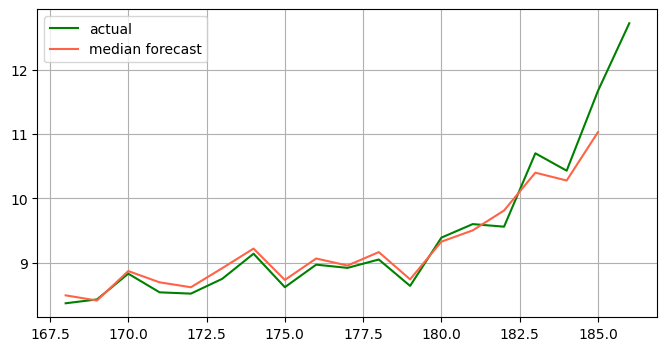

In [17]:
import matplotlib.pyplot as plt
forecast_index = range(train_length, train_length + test_length)
index = 'XPEV'
plt.figure(figsize=(8, 4))
#plt.plot(range(train_length),train_raw[index].values, color="royalblue", label="historical data")
plt.plot(forecast_index, test[index].values, color="green", label="actual")
plt.plot(forecast_index[:-1], pred_chronos_day[index][1:], color="tomato", label="median forecast")
plt.legend()
plt.grid()
plt.show()

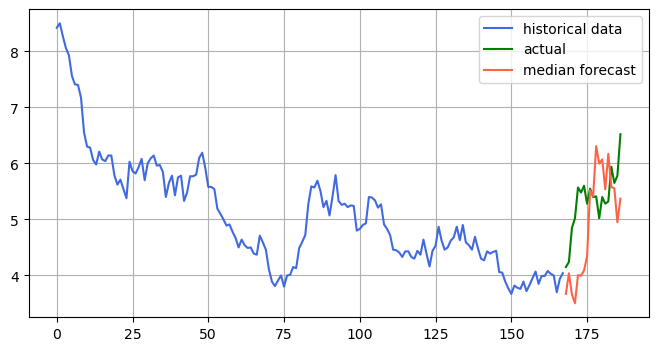

In [ ]:
forecast_index = range(train_length, train_length + test_length)
index = 'NIO'
plt.figure(figsize=(8, 4))
plt.plot(range(train_length),train_raw[index].values, color="royalblue", label="historical data")
plt.plot(forecast_index, test[index].values, color="green", label="actual")
plt.plot(forecast_index, pred_chronos_week[index], color="tomato", label="median forecast")
plt.legend()
plt.grid()
plt.show()

In [20]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
def preprocess(data, freq):
    scaler = StandardScaler()
    rft = np.fft.rfft(data)
    rft[freq:] = 0
    smooth = np.fft.irfft(rft)
    smooth[:2], smooth[-2:] = data.iloc[:2], data.iloc[-2:]
    smooth = scaler.fit_transform(smooth.reshape(-1,1))
    return smooth, scaler
pred_ets_day = {}
pred_ets_week = {}

for x in stock_symbols:
    pred_day = []
    pred_week = []
    for y in range(test_length):
        data, cur_scaler = preprocess(train_test_raw[x].iloc[:train_length + y], freq=-1)
        model = ETSModel(data.squeeze(), seasonal='add', seasonal_periods=4, error="add",trend="add",).fit()
        cur_pred = model.forecast(1)
        cur_pred = cur_scaler.inverse_transform(cur_pred.reshape(-1, 1))
        pred_day.append(cur_pred[0].squeeze())

        data, cur_scaler = preprocess(train_test_raw[x].iloc[:train_length + y - 5], freq=-1)
        model = ETSModel(data.squeeze(), seasonal='add', seasonal_periods=4, error="add",trend="add",).fit()
        cur_pred = model.forecast(5)
        cur_pred = cur_scaler.inverse_transform(cur_pred.reshape(-1, 1))
        pred_week.append(cur_pred.squeeze()[-1])

    pred_ets_day[x] = pred_day
    pred_ets_week[x] = pred_week

pred_ets_day['TSLA']


[array(212.8738564),
 array(210.5010054),
 array(219.68161803),
 array(229.52505955),
 array(209.31666188),
 array(216.53959783),
 array(226.37101983),
 array(227.15689948),
 array(228.74698855),
 array(230.7320428),
 array(227.40826663),
 array(227.00112031),
 array(226.05849402),
 array(244.49380644),
 array(239.14050016),
 array(248.82999563),
 array(253.52087204),
 array(257.41614813),
 array(255.04887352)]

In [21]:
mase_ets_day = {}
mape_ets_day = {}
for x in stock_symbols:
    mase_ets_day[x], mape_ets_day[x] = MASE(train_test_raw[x], pred_ets_day[x], 1, test_length)
    print(f"{x}: {mase_ets_day[x]}")
np.mean(list(mase_ets_day.values()))

RIVN: 0.9816110037724158
TSLA: 1.0219398759259082
NIO: 1.0713340939330447
XPEV: 0.9522068021196249
EVGO: 1.012553638781768
LI: 1.023797812583097
INDI: 0.9860605335923487
CHPT: 1.0142263750262115
LCID: 0.9942183222978085
LAZR: 1.0582666585382259


1.0116215116570453

In [22]:
mase_ets_week = {}
mape_ets_week = {}
for x in stock_symbols:
    mase_ets_week[x], mape_ets_week[x] = MASE(train_test_raw[x], pred_ets_week[x], 5, test_length)
    print(f"{x}: {mase_ets_week[x]}")
np.mean(list(mase_ets_week.values()))

RIVN: 0.9792694915704433
TSLA: 1.1993754126904876
NIO: 1.2505324555260888
XPEV: 1.0916713673265925
EVGO: 1.1366681869046618
LI: 1.242443931354187
INDI: 0.9666795829581126
CHPT: 1.1892474481101754
LCID: 1.0184236604219832
LAZR: 1.060880755043439


1.1135192291906173

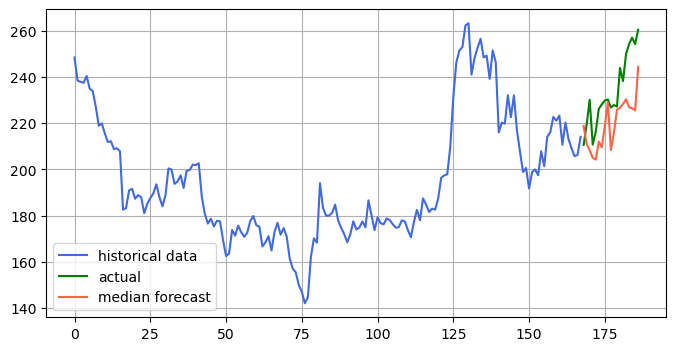

In [23]:
import matplotlib.pyplot as plt
forecast_index = range(train_length, train_length + test_length)
index = 'TSLA'
plt.figure(figsize=(8, 4))
plt.plot(range(train_length),train_raw[index].values, color="royalblue", label="historical data")
plt.plot(forecast_index, test[index].values, color="green", label="actual")
plt.plot(forecast_index, pred_ets_week[index], color="tomato", label="median forecast")
plt.legend()
plt.grid()
plt.show()